In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report,roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plant_village = '/kaggle/input/plantvillage-dataset/color'

In [3]:
train, test = tf.keras.utils.image_dataset_from_directory(plant_village,
                                                         image_size=(224,224),
                                                         batch_size=64,
                                                         seed=123,
                                                         validation_split=0.2,
                                                         subset='both')

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Using 10861 files for validation.


In [4]:
from tensorflow.keras.applications import ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 0s 0us/step


In [5]:
for layer in resnet_base.layers:
    layer.trainable = True

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255,input_shape=(224,224,3)),
    
    resnet_base,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(38,activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0

In [8]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=1000,decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [9]:
model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 patience = 5,
                                                 restore_best_weights = True)

In [11]:
history = model.fit(train, epochs=8, validation_data=test,callbacks=[early_stopping])

Epoch 1/8
679/679 [==============================] - 287s 353ms/step - loss: 1.0739 - accuracy: 0.7303 - val_loss: 7.6134 - val_accuracy: 0.0236
Epoch 2/8
679/679 [==============================] - 234s 344ms/step - loss: 0.3139 - accuracy: 0.9187 - val_loss: 0.8697 - val_accuracy: 0.7573
Epoch 3/8
679/679 [==============================] - 234s 344ms/step - loss: 0.1964 - accuracy: 0.9472 - val_loss: 0.2005 - val_accuracy: 0.9429
Epoch 4/8
679/679 [==============================] - 234s 344ms/step - loss: 0.1301 - accuracy: 0.9661 - val_loss: 0.1175 - val_accuracy: 0.9646
Epoch 5/8
679/679 [==============================] - 235s 345ms/step - loss: 0.1115 - accuracy: 0.9704 - val_loss: 0.3101 - val_accuracy: 0.9144
Epoch 6/8
679/679 [==============================] - 234s 345ms/step - loss: 0.0842 - accuracy: 0.9781 - val_loss: 1.0442 - val_accuracy: 0.7800
Epoch 7/8
679/679 [==============================] - 235s 345ms/step - loss: 0.0731 - accuracy: 0.9807 - val_loss: 0.0944 - val_ac

In [20]:
true_labels = [l for x,l in test.unbatch()]

In [21]:
predictions = model.predict(test)
predicted_labels = tf.argmax(predictions,axis=1)
print(classification_report(true_labels, predicted_labels))

170/170 [==============================] - 19s 106ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       120
           1       0.99      0.91      0.95       124
           2       1.00      0.93      0.96        56
           3       0.92      0.99      0.96       348
           4       0.97      1.00      0.98       318
           5       0.99      0.95      0.97       208
           6       0.88      1.00      0.94       147
           7       0.94      0.76      0.84       109
           8       0.96      1.00      0.98       238
           9       0.89      0.96      0.92       200
          10       1.00      1.00      1.00       247
          11       1.00      0.65      0.79       229
          12       0.94      1.00      0.97       274
          13       1.00      0.97      0.99       219
          14       1.00      0.62      0.76        94
          15       0.99      1.00      1.00      1137
          16       1.00

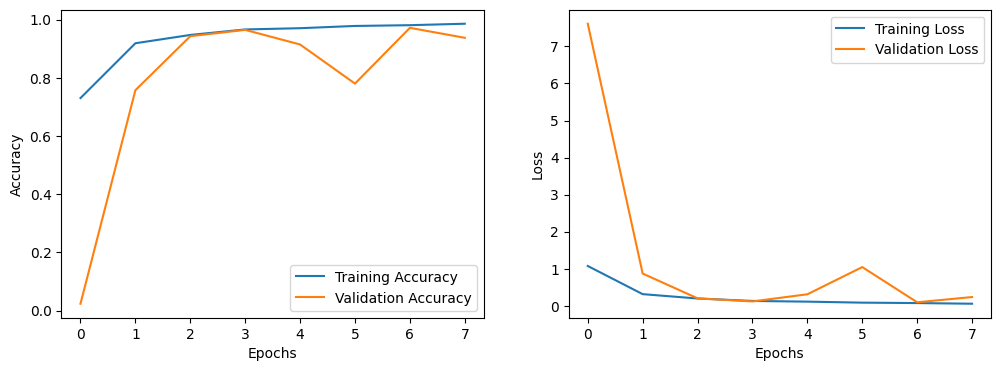

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [24]:
tloh = tf.one_hot(true_labels, depth=38)
ploh = tf.one_hot(predicted_labels, depth=38)
roc_auc = roc_auc_score(tloh,ploh, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc)

ROC AUC SCORE:  0.9595881274886462


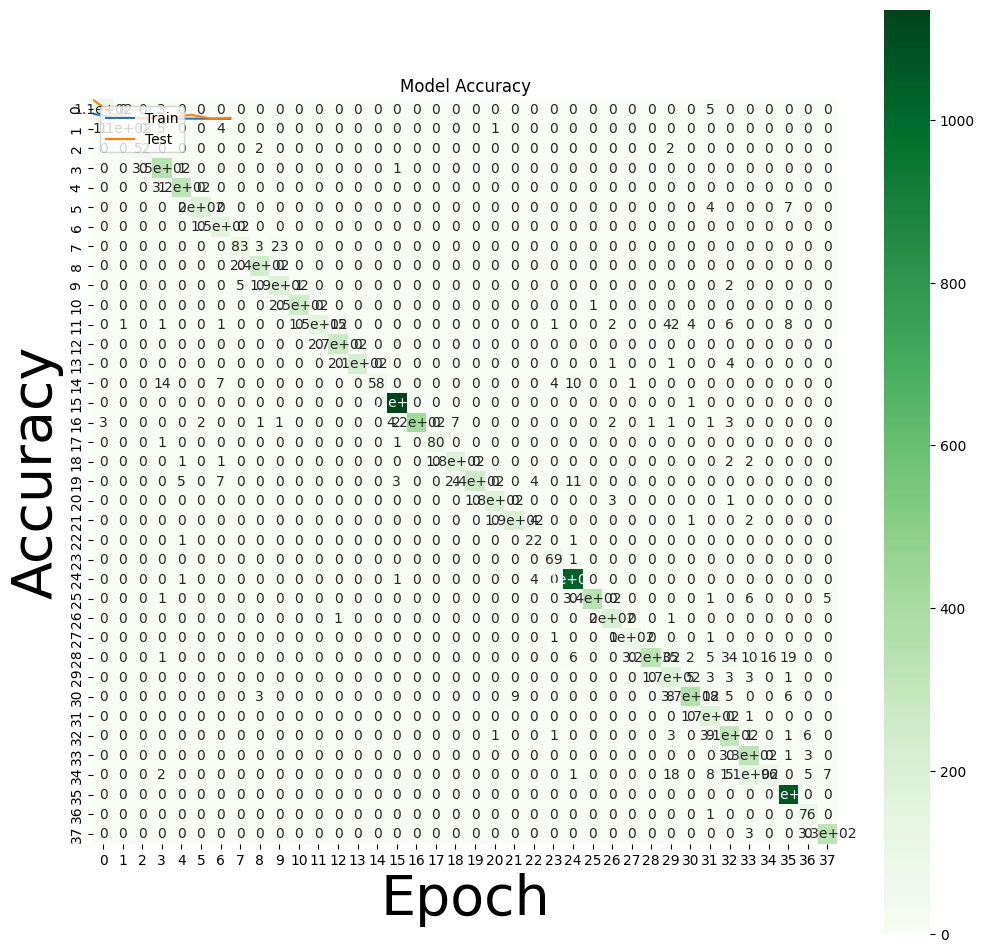

In [25]:
class_names = [i for i in range(38)]
cm = confusion_matrix(true_labels,predicted_labels)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  # Calculate model accuracy
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [34]:
calculate_results(true_labels,predicted_labels)

{'accuracy': 93.73906638431083,
 'precision': 0.9459637151230159,
 'recall': 0.9373906638431083,
 'f1': 0.9350204754348115}

In [13]:
mobilenet_base = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False,input_shape=(224,224,3))

17225924/17225924 [==============================] - 0s 0us/step


In [14]:
for layer in mobilenet_base.layers:
    layer.trainable = True

In [15]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255,input_shape=(224,224,3)),
    
    mobilenet_base,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(38,activation='sigmoid')
])

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization_96 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                      

In [17]:
model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [19]:
history2 = model2.fit(train, epochs=10, validation_data=test,callbacks=[early_stopping])

Epoch 1/10
679/679 [==============================] - 117s 159ms/step - loss: 3.0141 - accuracy: 0.2588 - val_loss: 1.5763 - val_accuracy: 0.6464
Epoch 2/10
679/679 [==============================] - 105s 154ms/step - loss: 1.9398 - accuracy: 0.4919 - val_loss: 1.1590 - val_accuracy: 0.7771
Epoch 3/10
679/679 [==============================] - 105s 155ms/step - loss: 1.5707 - accuracy: 0.5961 - val_loss: 0.9188 - val_accuracy: 0.8337
Epoch 4/10
679/679 [==============================] - 105s 154ms/step - loss: 1.3426 - accuracy: 0.6598 - val_loss: 0.7558 - val_accuracy: 0.8657
Epoch 5/10
679/679 [==============================] - 105s 154ms/step - loss: 1.1864 - accuracy: 0.7061 - val_loss: 0.6395 - val_accuracy: 0.8874
Epoch 6/10
679/679 [==============================] - 105s 154ms/step - loss: 1.0569 - accuracy: 0.7396 - val_loss: 0.5435 - val_accuracy: 0.9009
Epoch 7/10
679/679 [==============================] - 104s 153ms/step - loss: 0.9618 - accuracy: 0.7650 - val_loss: 0.4743 -

In [28]:
predictions2 = model2.predict(test)
predicted_labels2 = tf.argmax(predictions2,axis=1)
print(classification_report(true_labels, predicted_labels2))

170/170 [==============================] - 10s 55ms/step
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       120
           1       0.96      0.87      0.92       124
           2       1.00      0.45      0.62        56
           3       0.90      0.99      0.94       348
           4       0.99      1.00      1.00       318
           5       0.95      0.98      0.96       208
           6       0.94      0.99      0.96       147
           7       0.82      0.72      0.76       109
           8       1.00      1.00      1.00       238
           9       0.85      0.91      0.88       200
          10       0.99      1.00      1.00       247
          11       0.94      0.93      0.93       229
          12       0.94      0.97      0.96       274
          13       0.99      0.99      0.99       219
          14       0.99      0.93      0.96        94
          15       1.00      1.00      1.00      1137
          16       0.90 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


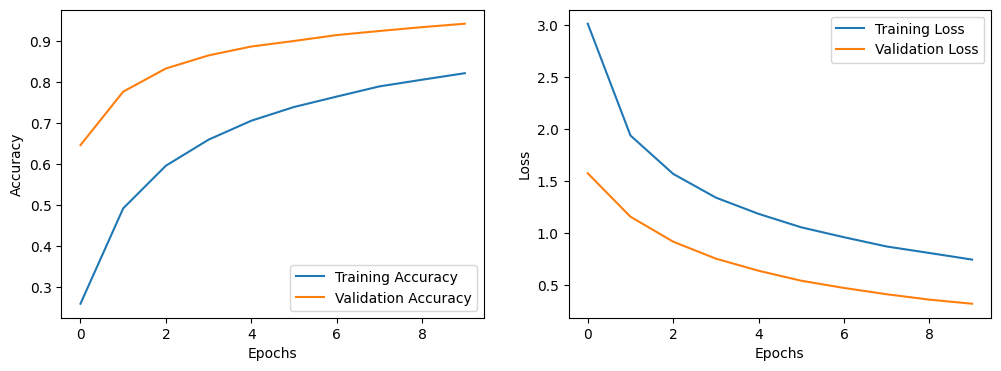

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
ploh2 = tf.one_hot(predicted_labels2, depth=38)
roc_auc2 = roc_auc_score(tloh,ploh2, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc2)

ROC AUC SCORE:  0.9306269084237137


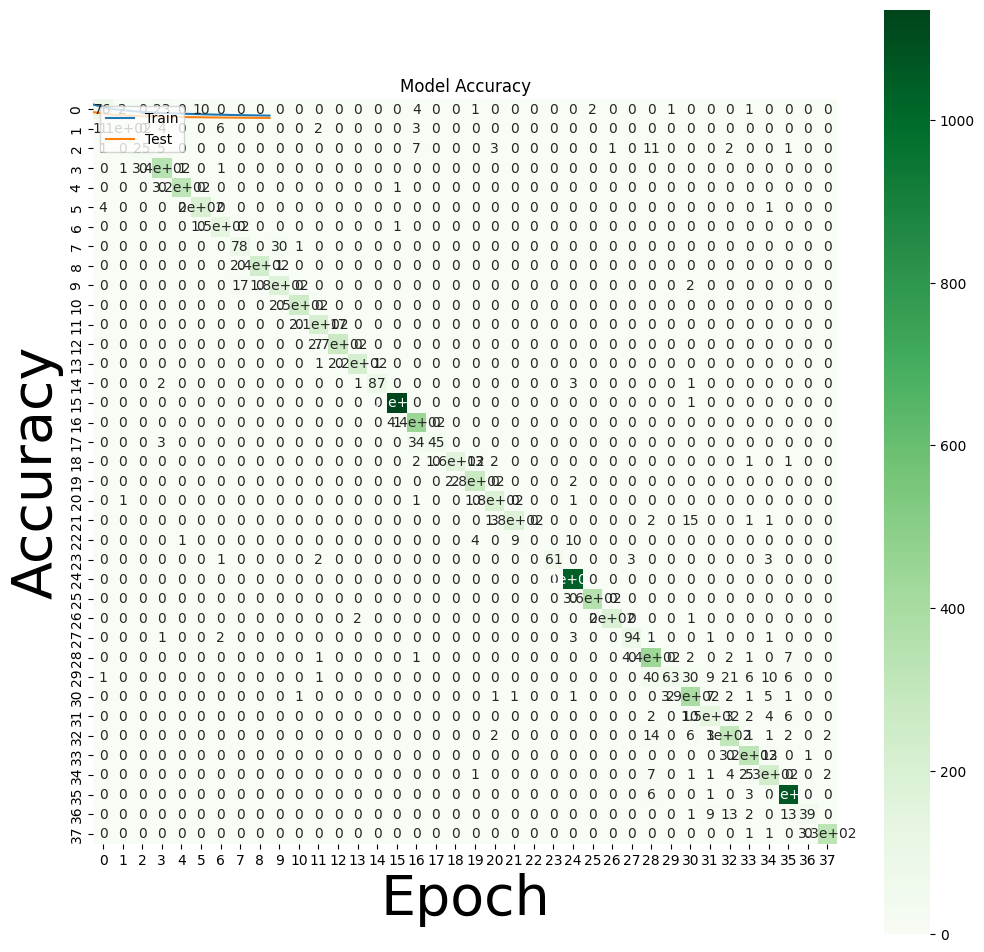

In [30]:
cm = confusion_matrix(true_labels,predicted_labels2)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [33]:
calculate_results(true_labels,predicted_labels2)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 94.30991621397662,
 'precision': 0.943249228026145,
 'recall': 0.9430991621397662,
 'f1': 0.9380006069342423}